## Processing Pipeline

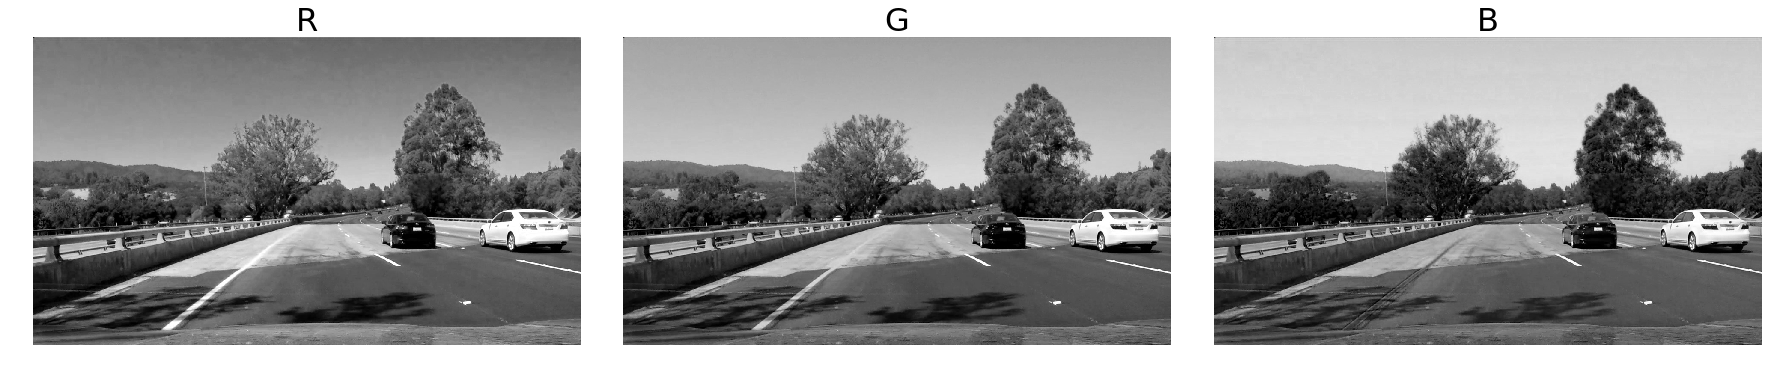

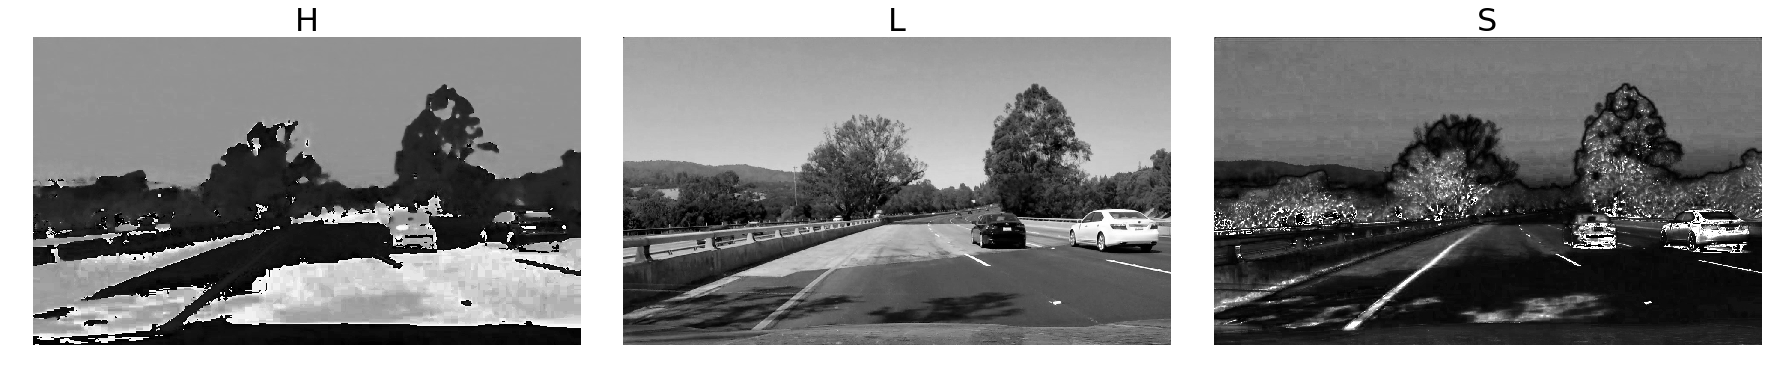

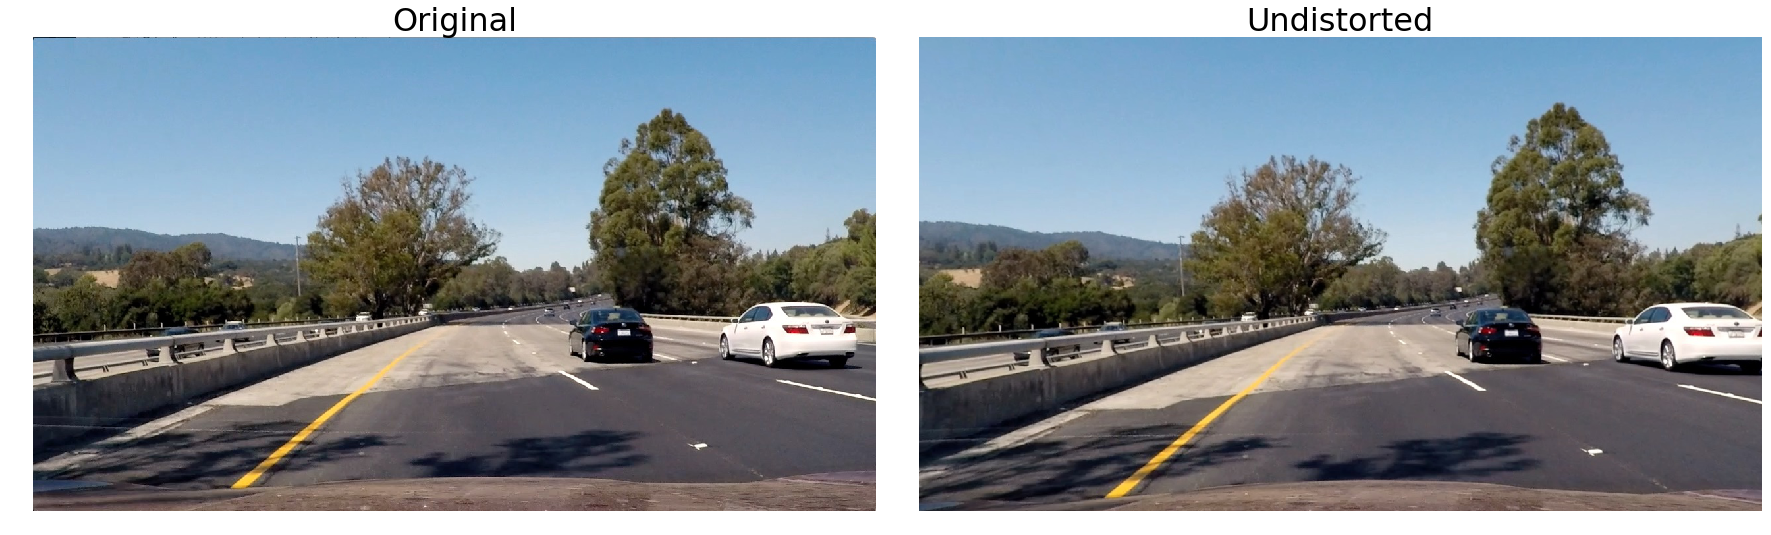

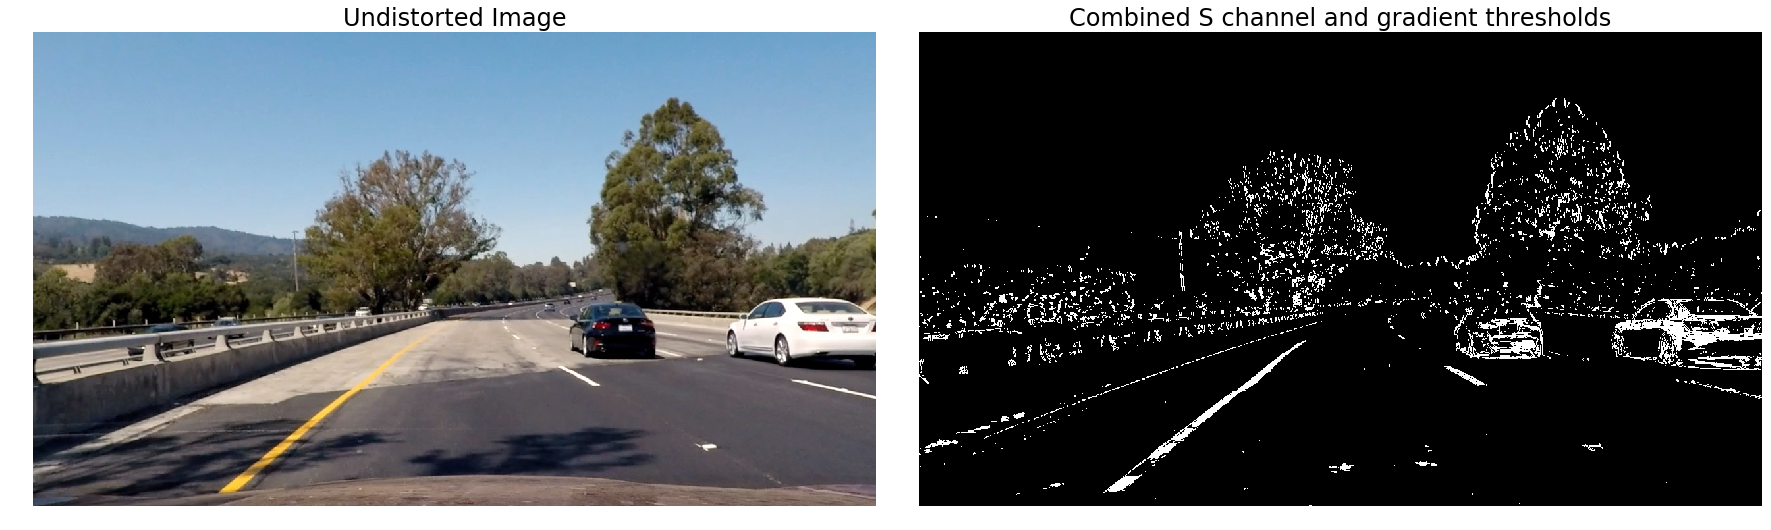

In [21]:
import numpy as np
import imageio
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# load Calibration data
dist_pickle = pickle.load( open( "./wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def pipeline_undistort(img):
    """ Undistorts the input image. """
    global mtx, dist
    
    return cv2.undistort(img, mtx, dist, None, mtx)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """

    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image, mask

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def comb_bin(img, thresh=(170, 255), s_thresh=(40, 120)):
    rawImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(rawImg, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = s_thresh[0]
    s_thresh_max = s_thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

def binarize(img, thresh=(170, 255), s_thresh=(40, 120)):
    rawImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(rawImg, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient and color
    color_gradient_binary = np.zeros_like(s_channel)
    color_gradient_binary[((s_channel >= thresh[0]) & (s_channel <= thresh[1])) | ((scaled_sobel >= s_thresh[0]) & (scaled_sobel <= s_thresh[1]))] = 1
    return color_gradient_binary

def extract_rgb(img):
    R = np.zeros(img.shape, dtype='uint8')
    G = np.zeros(img.shape, dtype='uint8')
    B = np.zeros(img.shape, dtype='uint8')
    
    R[:,:,0] = img[:,:,0]
    G[:,:,1] = img[:,:,1]
    B[:,:,2] = img[:,:,2]
    
    return R,G,B

def extract_hls(img):
    H = np.zeros(img.shape, dtype='uint8')
    L = np.zeros(img.shape, dtype='uint8')
    S = np.zeros(img.shape, dtype='uint8')
    
    H[:,:,0] = img[:,:,0]
    L[:,:,1] = img[:,:,1]
    S[:,:,2] = img[:,:,2]
    
    return R,G,B

def threshold(img, thresh_min=0, thresh_max=255):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh_min) & (img <= thresh_max)] = 1
    return binary_output

def magThresh(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Calculate the Sobel magnitude gradient and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    return threshIt(gradmag, thresh_min, thresh_max)

def dirThresh(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    """
    Calculate the Sobel direction gradient and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return threshIt(absgraddir, thresh_min, thresh_max)

# test undistort
rawImg = cv2.imread('./test_images/test4.jpg')
rawImg = cv2.cvtColor(rawImg, cv2.COLOR_BGR2RGB)
hls = cv2.cvtColor(rawImg, cv2.COLOR_RGB2HLS)
gray = cv2.cvtColor(rawImg, cv2.COLOR_RGB2GRAY)

R = rawImg[:,:,0]
G = rawImg[:,:,1]
B = rawImg[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R, cmap='gray')
ax1.axis('off')
ax1.set_title('R', fontsize=32)
ax2.imshow(G, cmap='gray')
ax2.axis('off')
ax2.set_title('G', fontsize=32)
ax3.imshow(B, cmap='gray')
ax3.axis('off')
ax3.set_title('B', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H, cmap='gray')
ax1.axis('off')
ax1.set_title('H', fontsize=32)
ax2.imshow(L, cmap='gray')
ax2.axis('off')
ax2.set_title('L', fontsize=32)
ax3.imshow(S, cmap='gray')
ax3.axis('off')
ax3.set_title('S', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

orig = cv2.imread('./test_images/test4.jpg')

rawImg = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
undist = pipeline_undistort(rawImg)
# imageio.imwrite('./output_images/undistorted_image.jpg', undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(rawImg)
ax1.axis('off')
ax1.set_title('Original', fontsize=32)
ax2.imshow(undist)
ax2.axis('off')
ax2.set_title('Undistorted', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

color_gradient_binary = binarize(undist)*255.0

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=24)
ax1.axis('off')
ax2.imshow(color_gradient_binary, cmap='gray')
ax2.set_title('Combined S channel and gradient thresholds', fontsize=24)
ax2.axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# imageio.imwrite('./output_images/binary.jpg', color_gradient_binary)


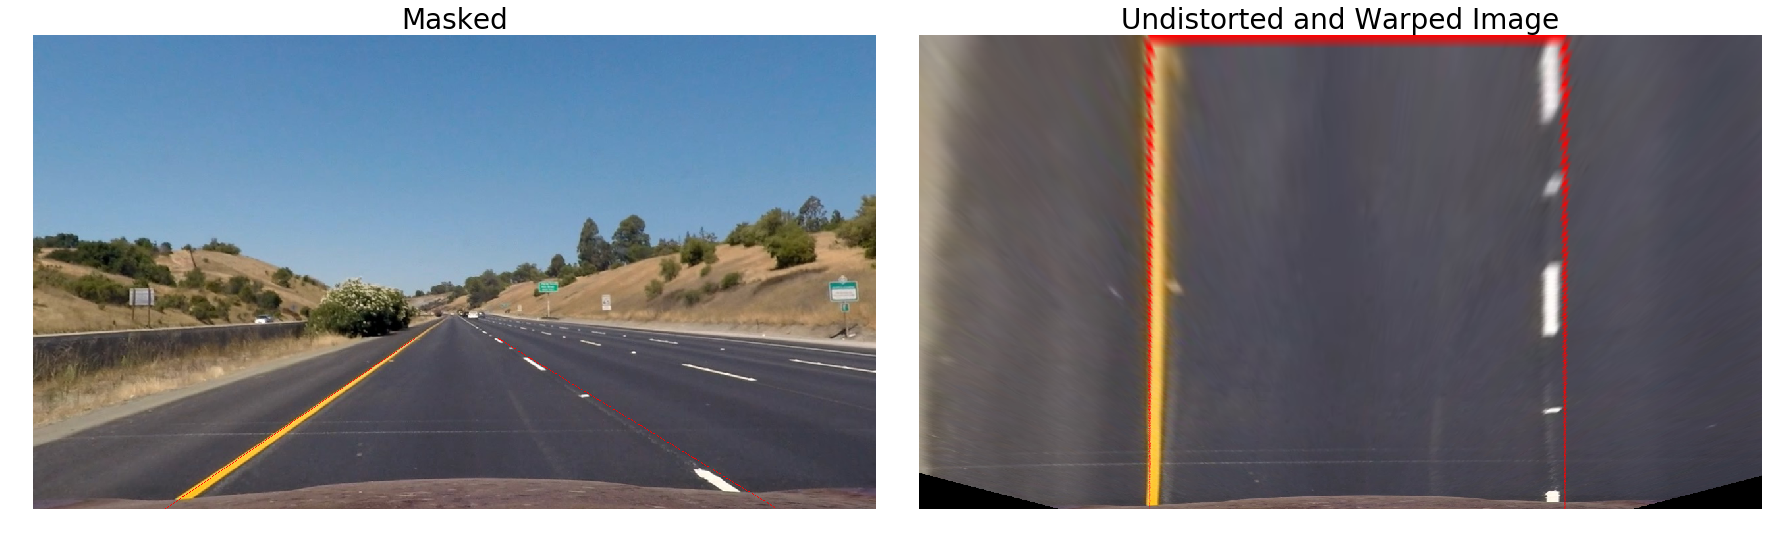

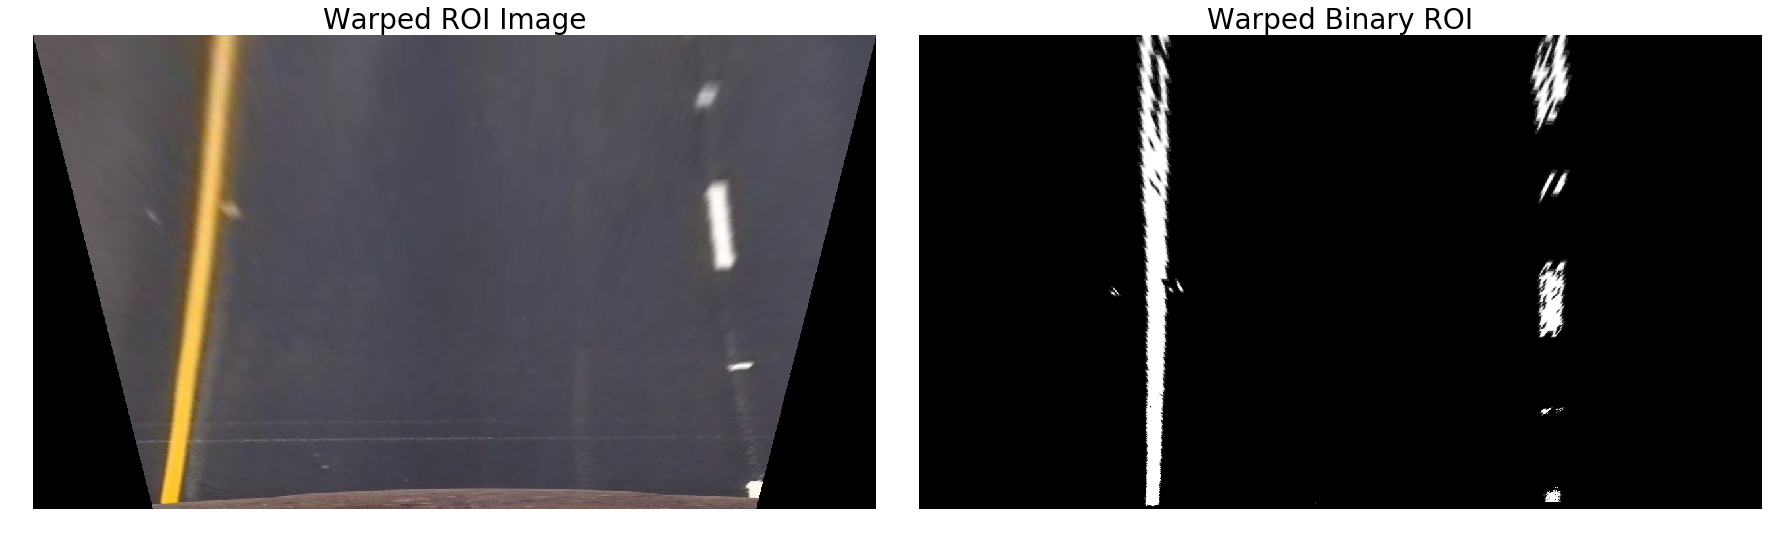

In [3]:

def source_points(img):
    
    corners = np.float32([[200,720],[580,460],[705,460],[1130,720]])
    imshape = img.shape
    region_image = img.copy()

    corner_tuples=[]
    for ind,c in enumerate(corners):
        corner_tuples.append(tuple(corners[ind]))

    cv2.line(region_image, corner_tuples[0], corner_tuples[1], color=[255,0,0], thickness=1)
    cv2.line(region_image, corner_tuples[1], corner_tuples[2], color=[255,0,0], thickness=1)
    cv2.line(region_image, corner_tuples[2], corner_tuples[3], color=[255,0,0], thickness=1)
    cv2.line(region_image, corner_tuples[3], corner_tuples[0], color=[255,0,0], thickness=1)
    
    return region_image

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    shape = img.shape
    vertices = np.array([[(0,0),(shape[1],0),(shape[1],0),(6*shape[1]/7,shape[0]),
                      (shape[1]/7,shape[0]), (0,0)]],dtype=np.int32)

    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def warp(img,tobird=True):
    corners = np.float32([[200,720],[580,460],[705,460],[1130,720]])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])
    offset=[150,0]
    
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([corners[0],corners[1],corners[2],corners[3]])
    dst = np.float32([corners[0]+offset,new_top_left+offset,new_top_right-offset ,corners[3]-offset])    
    M = cv2.getPerspectiveTransform(src, dst)    
    warped = cv2.warpPerspective(img, M, img_size , flags=cv2.INTER_LINEAR)    
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minv

def perspective_transform(img):
    width = img.shape[1]
    height = img.shape[0]
    src = np.array([[(width*0.4, height*0.65),
                        (width*0.6, height*0.65),
                        (width, height),
                        (0, height)]], 
                        dtype=np.float32)
    dst = np.array([[0,0], 
                    [img.shape[1], 0], 
                    [img.shape[1], img.shape[0]],
                    [0, img.shape[0]]],
                    dtype = 'float32')
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped_output = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped_output, M, Minv

def warp_pipeline(img):
    undist = pipeline_undistort(img)    
    result, M, Minv = perspective_transform(undist)
    result = region_of_interest(result)
    return result, M, Minv

def warp_binarize_pipeline(img):
    undist = pipeline_undistort(img)    
    binary = binarize(undist)*255.0
    result, M, Minv  = warp(binary)
    result = region_of_interest(result)
    return result,M,Minv 

orig = cv2.imread('./test_images/straight_lines1.jpg')
rawImg = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
undist = pipeline_undistort(rawImg)   
src_img = source_points(undist)
warped, M, Minv = warp(src_img)

warp_roi,M,Minv = warp_pipeline(rawImg)

warp_binary_roi,M,Minv = warp_binarize_pipeline(rawImg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(src_img, cmap='gray')
ax1.axis('off')
ax1.set_title('Masked', fontsize=28)
ax2.imshow(warped)
ax2.axis('off')
ax2.set_title('Undistorted and Warped Image', fontsize=28)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warp_roi)
ax1.axis('off')
ax1.set_title('Warped ROI Image', fontsize=28)
ax2.imshow(warp_binary_roi, cmap='gray')
ax2.axis('off')
ax2.set_title('Warped Binary ROI', fontsize=28)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# imageio.imwrite('./output_images/corners.jpg', src_img)
# imageio.imwrite('./output_images/warped.jpg', warped)
# imageio.imwrite('./output_images/warped_roi.jpg', warp_roi)
# imageio.imwrite('./output_images/warped_bin_roi.jpg', warp_binary_roi)



Text(0.5,1,'Warped binary ROI')

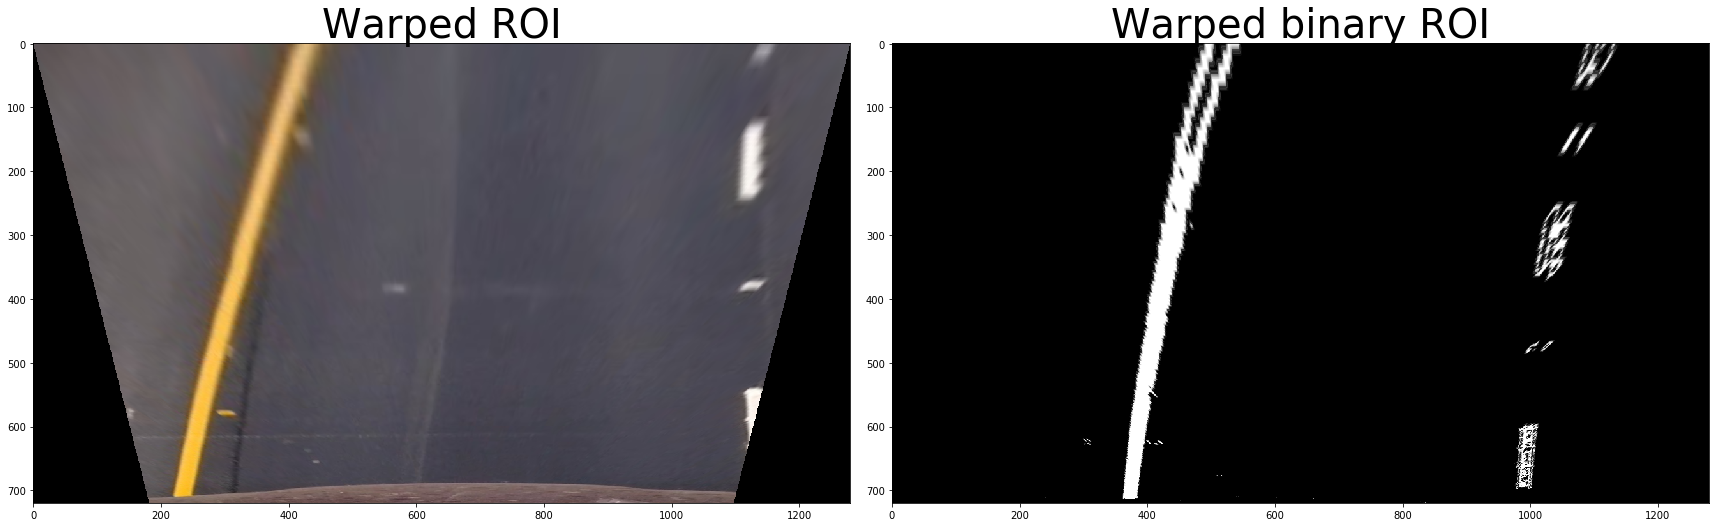

In [4]:
test_img = plt.imread('./test_images/test3.jpg')
warped,M,Minv = warp_pipeline(test_img)
warped_binary,M,Minv = warp_binarize_pipeline(test_img)

# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Warped ROI', fontsize=40)

ax2.imshow(warped_binary, cmap='gray')
ax2.set_title('Warped binary ROI', fontsize=40)

# imageio.imwrite('./output_images/warped_bin.jpg', warped_binary)

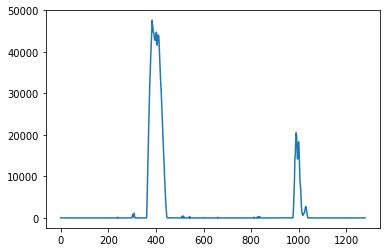

In [5]:
# Line Finding Method: Peaks in a Histogram
histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# plt.savefig('./output_images/histogram.jpg')


(720, 0)

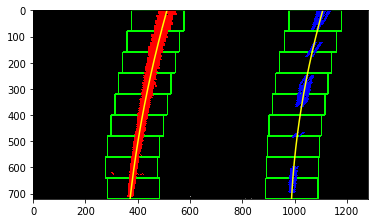

In [6]:

# Create an output image to draw on and  visualize the result
rows1, cols1 = warped_binary.shape[:2]

out_img = np.zeros((rows1,cols1,3),dtype='uint8')
out_img[:rows1, :cols1, :] = np.dstack((warped_binary, warped_binary, warped_binary))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped_binary.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_binary.shape[0] - (window+1)*window_height
    win_y_high = warped_binary.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# plt.savefig('./output_images/sliding_fit.jpg')

(720, 0)

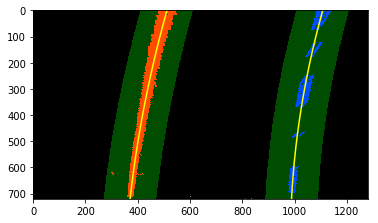

In [7]:
# Create an image to draw on and an image to show the selection window
rows1, cols1 = warped_binary.shape[:2]

out_img = np.zeros((rows1,cols1,3),dtype='uint8')
out_img[:rows1, :cols1, :] = np.dstack((warped_binary, warped_binary, warped_binary))*255

window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# plt.savefig('./output_images/sliding_fit_vis.jpg')

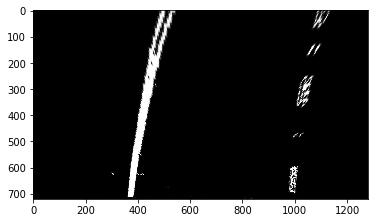

Text(0.5,1,'window fitting results')

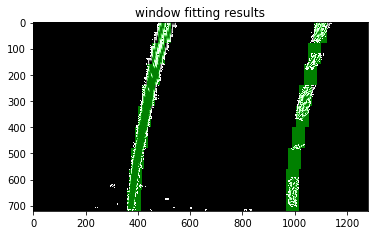

In [8]:
import matplotlib.image as mpimg

# Read in a thresholded image
warped = mpimg.imread('./output_images/warped_bin.jpg')

plt.imshow(warped, cmap='gray')
plt.show()

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')

# plt.savefig('./output_images/sliding_search_vis.jpg')

1495.70958077 1783.54015243
490.62331821 m 585.564630989 m


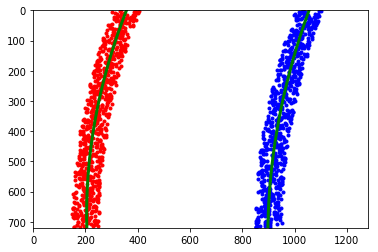

In [9]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

# plt.savefig('./output_images/measure_curve_vis.jpg')

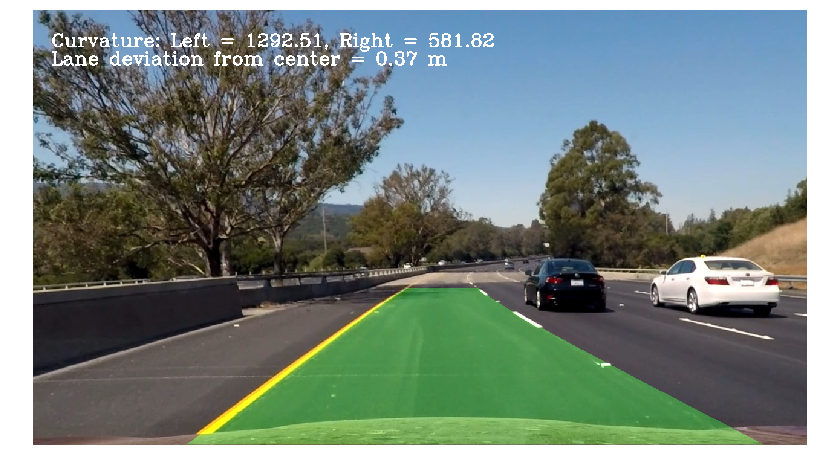

In [10]:
def get_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    y_eval = np.max(ploty)
    
    # Calculate curvature in pixel-space.
    
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    ## Example values: 1926.74 1908.48
    
    # Convert from pixels to metres.
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    # Calculate Lane Deviation from center of lane:
    # First we calculate the intercept points at the bottom of our image, then use those to 
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width / 2.0)
    
    return left_curverad, right_curverad, lane_deviation

def find_lane_lines(binary_warped, debug=False):
   
    if debug == True:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug == True:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    l, r, d = get_curvature(leftx, lefty, rightx, righty, ploty, binary_warped.shape)
    
    if debug == True:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img
    else:
        return left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d
    
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    curvature_text = 'Curvature: Left = ' + str(np.round(left_radius, 2)) + ', Right = ' + str(np.round(right_radius, 2)) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (255,255,255), 2)
    deviation_text = 'Lane deviation from center = {:.2f} m'.format(lane_deviation) 
    font = cv2.FONT_HERSHEY_COMPLEX    
    cv2.putText(result, deviation_text, (30, 90), font, 1, (255,255,255), 2)
        
    return result


test_img = plt.imread('./test_images/test6.jpg')
undistorted_img = pipeline_undistort(test_img)
binary_warped,M,Minv = warp_binarize_pipeline(test_img)


left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img = find_lane_lines(binary_warped, debug=True)
result = draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty, l, r, d)
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");

# plt.savefig('./output_images/highlight_lane_vis.jpg')


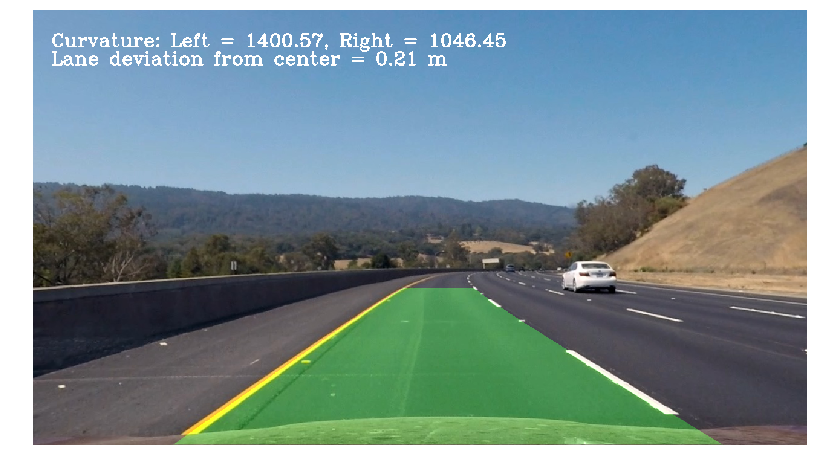

In [16]:
def video_pipeline(image):
    undistorted = pipeline_undistort(image)
    binary_warped,M,Minv = warp_binarize_pipeline(image)
    left_fitx, right_fitx, ploty, _, _, l, r, d = find_lane_lines(binary_warped)
    lane_lines_img = draw_lanes_on_image(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, l, r, d)
    return lane_lines_img

test_frame = plt.imread('./test_images/test3.jpg')
result = video_pipeline(test_frame)
plt.figure(figsize=(16,8))
plt.imshow(result)
plt.axis("off");

In [17]:
from moviepy.editor import VideoFileClip

video_output = "output_images/project_video_output.mp4"
vid_clip = VideoFileClip("./project_video.mp4")
frame_output = vid_clip.fl_image(video_pipeline) 
%time frame_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [04:44<00:00,  4.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

Wall time: 4min 45s


In [18]:

from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [19]:
challenge_output = "output_images/project_video_challenge_output.mp4"
vid_clip = VideoFileClip("challenge_video.mp4")
frame_output = vid_clip.fl_image(video_pipeline) 
%time frame_output.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_challenge_output.mp4
[MoviePy] Writing video output_images/project_video_challenge_output.mp4


100%|██████████| 485/485 [01:40<00:00,  5.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_challenge_output.mp4 

Wall time: 1min 41s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))